# Ensemble Tree Methods (continued)

but first...


## Hyper-parameter Search and Validation

Tree methods have many hyper-parameters compared to the algorithms we've encountered thus far. Here are some from the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

 - max_depth - how many layers may the tree have
 - min_samples_split - how many samples must be in a node to allow a split
 - min_samples_leaf - how many samples must be in a leaf
 - max_features - the number of features to consider in a split
 - max_leaf_nodes - stop growing the tree at a specified number of leaves
 - and others

### Grid Search

How do we explore this space? Suppose I want to try trees with these options:
 - max_depth = [4, 6, 8, 10, 12]
 - min_samples_split = [10, 20, 40]

 How many models will I be testing?

GridSearch does just this in an automated way, testing every combination from the parameters you'd like to test.

| max_depth | min_samples_split | Cartesian Product |
|-----------|-------------------|-------------------|
| 4         | 10                | (4, 10)           |
| 4         | 20                | (4, 20)           |
| 4         | 40                | (4, 40)           |
| 6         | 10                | (6, 10)           |
| 6         | 20                | (6, 20)           |
| 6         | 40                | (6, 40)           |
| 8         | 10                | (8, 10)           |
| 8         | 20                | (8, 20)           |
| 8         | 40                | (8, 40)           |
| 10        | 10                | (10, 10)          |
| 10        | 20                | (10, 20)          |
| 10        | 40                | (10, 40)          |
| 12        | 10                | (12, 10)          |
| 12        | 20                | (12, 20)          |
| 12        | 40                | (12, 40)          |


### Cross-Validation

Validation is used to select from a set of candidate models (e.g. different learning algorithms, variations on the same algorithm with different hyperparameters). In the simplest form of validation, we split off a portion of the training data and compare models based on their performance on this validation set. But more commonly, we use K-fold Cross-Validation: 


<img src="grid_search_cross_validation.png" alt="Grid Search Cross Validation" style="width:50%;">


 - Split the training data into K "folds"
 - Set the first fold aside as a validation set and train on the remaining data.
 - Validate using that first fold as a validation set.
 - Repeat the process (K times in total), each time using a different fold as the validation set.
 - Average the performance across all the training-validation iterations.



### Grid Search + Cross-Validation

Grid Search and Cross-Validation are used in tandem so commonly that sklearn packages them together in some very convenient functions.

 - [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
 - [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html), [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html), [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
 - [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

## Example: Palmer's Penguins

Let's try to predict the species of penguins based on measured attributes.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
rowid,,,,,,,,
1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, 1 to 344
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 24.2+ KB


None

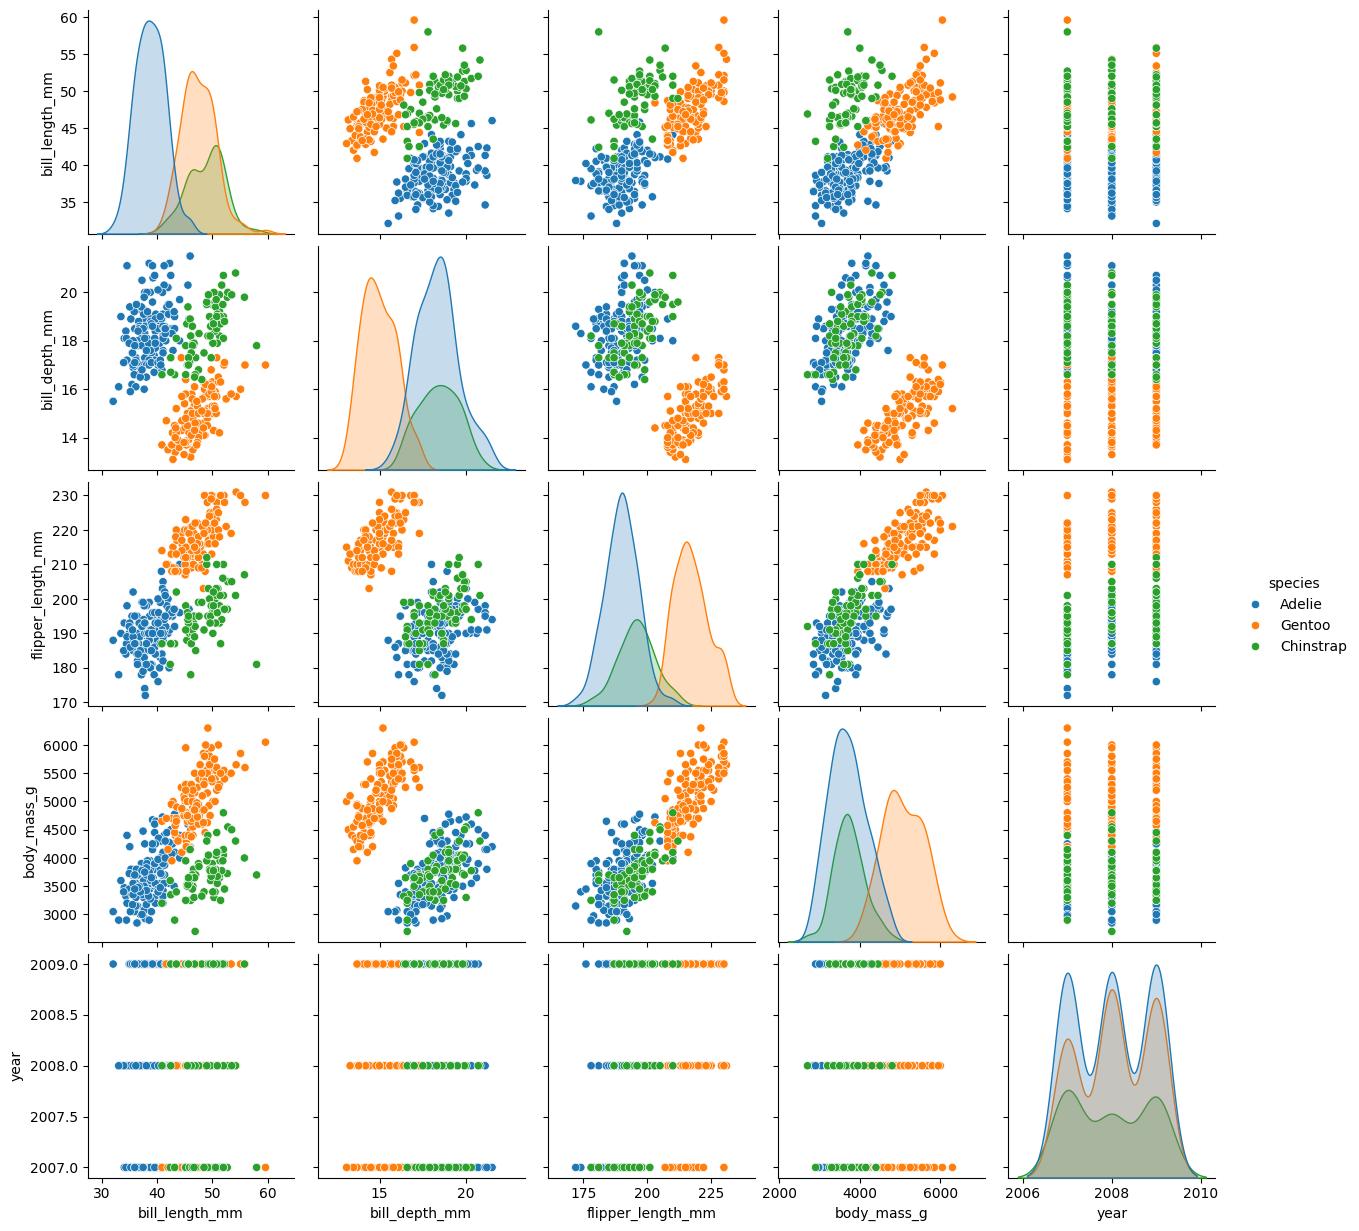

In [30]:
palmers = pd.read_csv('https://gist.githubusercontent.com/slopp/ce3b90b9168f2f921784de84fa445651/raw/4ecf3041f0ed4913e7c230758733948bc561f434/penguins.csv', index_col = 'rowid')

display(palmers.head())
display(palmers.info())

sns.pairplot(palmers, hue = 'species')
plt.show()

In [24]:
# Prepare the data
palmers.dropna(axis = 0, inplace=True)
palmers.reset_index(drop = True, inplace=True)
palmers

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
328,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
329,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
330,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
331,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009



## Decision/Classification Tree Recap

 - A decision tree classifies samples using a heirarchy of cascading conditional statements (yes-no questions about the sample).

 - In fitting a decision tree, at each node, a conditional statement is chosen so as to maximize the purity of the resultant split sub-samples.

 - Fitting a decision tree is deterministic. That is, given the same training data and hyper-parameters, you will arrive at the same tree.

There are challenges that come with real data that often cause problems for a decision tree:

 - High-dimensional data (many features)
 - Noisy data
 - Imbalanced class representation


 We can improve on an individual decision tree by fitting numerous decision trees---an *ensemble*---and averaging/polling their results. There are two main categories of ensemble methods for decision trees, Random Forests and Boosted Trees, each with their own benefits and weaknesses.



 ## Random Forests (RandomForestClassifier)

 A random forest creates numerous trees in parallel (at the same time). To make a prediction, a sample is processed by each tree, each tree makes a prediction, and the majority vote wins. But what makes the trees in the forest different from each other?

 In fitting, diversity of trees is created using two methods: feature selection and bagging.

### Random feature subsets

  Each tree only gets a subset of the features. For example, in a random forest deciding whether or not you should buy a car, one tree might make a prediction based on ['reliability', 'feul economy', 'price'], while another uses ['top speed', 'interior room', 'cost to repair'], and another uses ['resale value', 'feul economy', 'value of standard tech'] and another...

### Bagging (<ins>B</ins>ootstrap <ins>agg</ins>regat<ins>ing</ins>)

  *Bootstrapping* is a method for creating new data sets by sampling existing data sets. In bootstrapping, you select samples randomly and allow a sample to be selected multiple times (called sampling with replacement).

  *Bagging* is a method that uses bootstrapping to create different training sets for each tree, and then aggregating the results.

  The idea is that no one tree will be great, but they'll all make different mistakes. But there'll be more overlap in correct guesses than in mistakes. So for any given sample, the majority vote is more likely to be correct than any one tree.



## Boosted Trees

Whereas Random Forests fit trees in parallel and every tree gets an equal vote, Boosted trees create trees sequentially, each new tree focusing on the shortcomings of the previous. And at the voting stage, some trees get more say than others.

There are many flavors of Boosted trees: AdaBoost, XGBoost, CatBoost

They all work a little differently, but here's an outline of AdaBoost as an example:

### AdaBoost (<ins>Ada</ins>ptive <ins>Boost</ins>ing) ( ```GradientBoostingClassifier```)

In AdaBoost, a tree comprises only one decision node; this kind of tree is called a stump. In each iteration, a new stump is created that splits the data based on a different condition. As the algorithm iterates, it keeps track of:

- Sample Weight - each iteration, the algorithm focuses more on misclassified samples. 
   - A sample that is classified correctly is down-weighted. We get this right, don't spend more energy on this case.
   - A sample that is classified incorrectly is up-weighted. We get this wrong, focus on this case.

 - Tree Influence - how much say a tree will have in the final vote. Trees that do better at classifying get more say.
    - A tree that is 50% correct gets no say. This tree is just guessing
    - A tree that is >50% gets a positive vote (0 to infinity). A tree that is 100% correct gets infinite vote! Listen to that tree!
    - A tree that is <50% gets a negative vote (0 to -infinity). A tree that is 0% correct gets a -infinite vote! Do the opposite of that tree!


The AdaBoost process:
 1. Start with all the samples each counts the same. 
 2. Same as in a decision tree, pick a question that splits the data to minimize Gini Impurity.
 3. Sum up sample weights for mis-classified samples and calculate Tree Influence.
 4. Assign new weights to samples, increasing weights on mistakes and decreasing weights on correct classifications.
 5. Create new stump, and repeat 2-5 until classification error is below some threshold you choose.

When you predict, you feed the sample through all the stumps and each votes according to their influence.

## Some Pros and Cons

### Random Forests

**Pros:**
- Good for high-dimensional data
- Good for noisy data
- Easy to tune and fast to fit
- Low variance (doesn't over-fit data)

**Cons:**
- Can be slow to run

### Boosted Trees

**Pros:**
- Can get very accurate predictions (Low Bias)
- Good for imbalanced data sets

**Cons:**
- Prone to over-fitting
- Susceptible to noise
- Less interpretable